In [1]:
import google.generativeai as genai
import re 
from typing import List, Dict
genai.configure(api_key="API_KEY")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = genai.GenerativeModel("models/gemini-1.5-pro-latest")

In [3]:
def build_prompt_A(keywords: List[str], company_context: str) -> str:
    keyword_str = ", ".join(keywords)
    return f"""
You are an AI assistant helping generate search-style questions for SEO and advertising purposes.

Based on the following keywords: {keyword_str}
And the business context: "{company_context}"

Generate a list of **neutral, general-purpose questions** that someone might type into a search engine.

⚠️ Do NOT refer to any specific product, brand, website, or "this car".
⚠️ Do NOT use words like "you", "your", or "we".
Focus on questions that reflect comparison, curiosity, buying decisions, or feature exploration.
Each line should contain a **single, standalone** question.

Output format:
label: question
(Example labels: compare, decide, explore, research)

Only output the labeled questions, one per line. No bullet points or extra text.
"""


In [4]:
def build_abstract_prompt_A(keywords: List[str], company_context: str) -> str:
    joined_keywords = ", ".join(f'"{k}"' for k in keywords)

    return f"""
You are an AI assistant trained to simulate natural user search behavior.

Keywords: {joined_keywords}
Business context: "{company_context}"

Your task is to generate questions that:
- Reflect the **same intent and meaning** as the above keywords
- Do **not use the keywords** or any direct synonyms
- Still lead users to relevant product/service pages if typed into a search engine

Guidelines:
- Avoid keyword phrases or synonyms
- Sound natural and human-like
- Each question on a new line with no numbering
"""


In [5]:
def build_prompt_B(keywords: List[str], company_context: str) -> str:
    keyword_str = ", ".join(keywords)
    return f"""
Generate search-style questions a person might ask if they are interested in: {keyword_str}.

The context is: {company_context} (automotive industry).

Make the questions sound like natural user queries. 
Each question should:
- Be realistic
- Contain the keyword
- Be curious, comparison-based, or decision-related

Format:
label: question

Examples: compare: what is the best value electric SUV?, decide: should I lease or buy an EV?

Return only the questions, no commentary.
"""

In [6]:
def build_abstract_prompt_B(keywords: List[str], company_context: str) -> str:
    return f"""
Imagine people are searching online for something related to the {company_context} industry. 

Generate questions that:
- Match the intent behind these keywords: {', '.join(keywords)}
- Do NOT use the keywords or obvious synonyms
- Still make sense to someone looking for a relevant product

Write natural human-style questions.

One question per line. No formatting or commentary.
"""


In [7]:

# ────────────────────────────────
# 2. Prompt Builder (Abstracted, No Keywords)
# ────────────────────────────────
def build_prompt_for_abstracted_questions(keywords: List[str], company_context: str) -> str:
    joined_keywords = ", ".join(f'"{k}"' for k in keywords)

    return f"""
You are an AI assistant trained to simulate natural user search behavior.

Keywords: {joined_keywords}
Business context: "{company_context}"

Your task is to generate questions that:
- Reflect the **same intent and meaning** as the above keywords
- Do **not use the keywords** or any direct synonyms
- Still lead users to relevant product/service pages if typed into a search engine

Guidelines:
- Avoid keyword phrases or synonyms
- Sound natural and human-like
- Each question on a new line with no numbering
"""

In [8]:
def generate_questions(prompt: str, labeled: bool = True, debug: bool = True) -> List[Dict[str, str]]:
    """
    Generate a list of search-style questions from Gemini based on a prompt.
    
    Args:
        prompt (str): The input prompt to Gemini.
        labeled (bool): Whether to expect intent labels like 'compare: ...'.
        debug (bool): Print raw Gemini output for inspection.
    
    Returns:
        List[Dict[str, str]]: A list of dicts with 'intent' and 'question' keys.
    """
    try:
        response = model.generate_content(prompt)
        raw_output = response.text.strip()

        if debug:
            print("\n🧠 Gemini Raw Output:\n" + raw_output)

        lines = raw_output.split("\n")
        questions = []

        for line in lines:
            clean_line = line.strip()
            if not clean_line or len(clean_line) < 10:
                continue  # skip empty or short lines

            if labeled:
                # Look for "intent: question" or "intent - question"
                match = re.match(r"([a-zA-Z0-9_ -]+)\s*[:\-–]\s*(.+)", clean_line)
                if match:
                    intent, question = match.groups()
                    questions.append({
                        "intent": intent.strip().lower(),
                        "question": question.strip()
                    })
                else:
                    # Fallback: assume it's just a question with unknown label
                    questions.append({
                        "intent": "unknown",
                        "question": clean_line
                    })
            else:
                # Abstracted version (not used here, but left for future use)
                questions.append({
                    "intent": "abstracted",
                    "question": clean_line
                })

        return questions

    except Exception as e:
        print(f"❌ Error generating questions: {e}")
        return []

In [30]:
def run_dual_question_mode(keywords: List[str], company_context: str):
    print(f"\n🧠 Running for keywords: {', '.join(keywords)}")

    # Generate direct questions
    prompt_direct = build_prompt(keywords, company_context)
    direct_questions = generate_questions(prompt_direct, labeled=False)
    #direct_eval = evaluate_questions(direct_questions)

    # Generate abstracted questions
    prompt_abstracted = build_prompt_for_abstracted_questions(keywords, company_context)
    abstracted_questions = generate_questions(prompt_abstracted, labeled=False)
    #abstracted_eval = evaluate_questions(abstracted_questions)

    # Display results
    print("\n📌 DIRECT QUESTIONS (based on keywords):")
    for q in direct_questions:
        print(f"→ {q['intent']}: {q['question']}")
    #print(f"📊 Evaluation: {direct_eval}")

    print("\n📌 ABSTRACTED QUESTIONS (same meaning, no keywords):")
    for q in abstracted_questions:
        print(f"→ {q['intent']}: {q['question']}")
    #print(f"📊 Evaluation: {abstracted_eval}")

    return {
        "direct": {"questions": direct_questions},
        "abstracted": {"questions": abstracted_questions}
    }

In [31]:
keywords = ["electric vehicle", "cheap family car"]
context = "Car company"
questions = run_dual_question_mode(keywords, context)



🧠 Running for keywords: electric vehicle, cheap family car


NameError: name 'build_prompt' is not defined

In [9]:
def count_relevant_reddit_posts(question: str, reddit_client, max_posts: int = 100) -> int:
    """
    Search Reddit for the question and count how many of the top post titles
    contain overlapping words with the question.

    Args:
        question (str): The generated question to evaluate.
        reddit_client (praw.Reddit): An authenticated Reddit client (PRAW).
        max_posts (int): Maximum number of posts to scan.

    Returns:
        int: Number of relevant Reddit titles (out of `max_posts`).
    """
    try:
        # Search Reddit
        results = reddit_client.subreddit("all").search(question, limit=max_posts)
        question_words = set(question.lower().split())
        matched = 0

        for post in results:
            title_words = set(post.title.lower().split())
            common = question_words & title_words
            if len(common) >= 2:
                matched += 1

        return matched

    except Exception as e:
        print(f"❌ Reddit error for question '{question}': {e}")
        return 0


In [10]:
import praw

# Setup your Reddit client
reddit = praw.Reddit(
    client_id="L_nmG8JZf59KOgT1tQBGlw",
    client_secret="yCsedpckhc85utc1iTjKj2MBGil0jA",
    user_agent="new_app_erez/0.1 by u/FindingKindly2754"
)



In [17]:

# Example question
q = "What is the best electric SUV for families?"
relevant_count = count_relevant_reddit_posts(q, reddit_client=reddit)
print(f"{q} → {relevant_count}/100 relevant")


🔍 What is the best electric SUV for families? → 12/100 relevant


In [11]:
def evaluate_prompt_relevance(
    questions: List[Dict[str, str]],
    reddit_client,
    max_posts_per_question: int = 100
) -> float:
    """
    Evaluate how relevant a list of questions is based on Reddit search results.

    Args:
        questions (List[Dict[str, str]]): List of questions (each with 'question' key).
        reddit_client: PRAW Reddit client.
        max_posts_per_question (int): How many posts to fetch per Reddit query.

    Returns:
        float: Average number of relevant Reddit hits per question.
    """
    total_score = 0
    question_count = 0

    for q in questions:
        question_text = q["question"]
        matches = count_relevant_reddit_posts(question_text, reddit_client, max_posts=max_posts_per_question)
        print(f"🔍 {question_text} → {matches}/100 relevant")
        total_score += matches
        question_count += 1

    if question_count == 0:
        return 0.0

    avg_score = total_score / question_count
    print(f"\n📊 Average relevance score: {avg_score:.2f} per question")
    return avg_score


In [19]:
keywords = ["electric vehicle", "cheap family car"]
context = "Car company"
prompt = build_prompt_A(keywords, context)
questions = generate_questions(prompt, labeled=True)
avg_relevance = evaluate_prompt_relevance(questions, reddit_client=reddit)



🧠 Gemini Raw Output:
research: What are the cheapest electric family cars?
compare: How do electric vehicles compare to gas-powered family cars in terms of cost?
decide: What factors should families consider when choosing between an electric and gasoline car?
explore: What are the benefits of owning an electric family car?
research: How much does it cost to charge an electric family car?
compare: What are the different types of electric family cars available?
decide: Is an electric car suitable for a large family?
explore: What are the maintenance costs of electric vehicles compared to gas cars?
research: What government incentives are available for purchasing electric family cars?
compare: How does the range of different electric vehicles compare?
decide: What safety features are important in an electric family car?
explore: How does the cargo space in electric vehicles compare to traditional family cars?
research: What are the best electric cars for families with young children?
com

In [12]:
def improve_prompt(prompt_a: str, prompt_b: str, score_a: float, score_b: float) -> str:
    """
    Ask Gemini to generate a new, improved prompt based on scores of A and B.

    Returns:
        str: The improved prompt text.
    """
    prompt = f"""
We are testing two prompts to generate search-style questions with keywords.

Prompt A (score: {score_a}):
\"\"\"{prompt_a.strip()}\"\"\"

Prompt B (score: {score_b}):
\"\"\"{prompt_b.strip()}\"\"\"

Please generate a new improved prompt that combines the strengths of both.
Avoid weaknesses. Make the instructions simple, clear, and effective.

The new prompt should create human like question that people might ask and agenet
Output only the new prompt (no explanation).
"""
    response = model.generate_content(prompt)
    return response.text.strip()


In [13]:
def run_ab_test_and_optimize(
    keywords: List[str],
    company_context: str,
    reddit_client
) -> Dict:
    """
    Runs A/B test between two direct (keyword-based) prompts and returns scores + optimized prompt.

    Args:
        keywords (List[str]): Keywords for prompt generation.
        company_context (str): Business/brand context.
        reddit_client: An authenticated PRAW Reddit client.

    Returns:
        Dict: Contains both prompts, scores, and improved prompt.
    """
    print("\n🧪 Running A/B test for DIRECT questions...")

    # Build prompts A & B
    prompt_a = build_prompt_A(keywords, company_context)
    prompt_b = build_prompt_B(keywords, company_context)

    # Generate questions
    questions_a = generate_questions(prompt_a, labeled=True)
    questions_b = generate_questions(prompt_b, labeled=True)

    # Score using Reddit
    print("\n📈 Scoring Prompt A...")
    score_a = evaluate_prompt_relevance(questions_a, reddit_client)

    print("\n📈 Scoring Prompt B...")
    score_b = evaluate_prompt_relevance(questions_b, reddit_client)

    # Generate improved prompt using Gemini
    improved_prompt = improve_prompt(prompt_a, prompt_b, score_a, score_b)

    # Display results
    print("\n🔧 Optimized Prompt:\n" + improved_prompt)

    return {
        "prompt_a": prompt_a,
        "score_a": score_a,
        "prompt_b": prompt_b,
        "score_b": score_b,
        "improved_prompt": improved_prompt
    }


In [14]:
results = run_ab_test_and_optimize(
    keywords=["electric vehicle", "cheap family car"],
    company_context="Mazda",
    reddit_client=reddit
)

print("\n✅ Final Optimized Prompt:\n", results["improved_prompt"])



🧪 Running A/B test for DIRECT questions...


KeyboardInterrupt: 

In [15]:
def optimize_prompt_loop(
    keywords: List[str],
    company_context: str,
    reddit_client,
    rounds: int = 3
) -> List[Dict]:
    """
    Runs multiple rounds of prompt optimization for direct questions.

    Args:
        keywords (List[str]): Keyword list.
        company_context (str): Brand or product context.
        reddit_client: Reddit API client (PRAW).
        rounds (int): How many optimization rounds to run.

    Returns:
        List[Dict]: List of optimization results from each round.
    """
    history = []

    # Initial Prompts A & B
    prompt_a = build_prompt_A(keywords, company_context)
    prompt_b = build_prompt_B(keywords, company_context)

    for i in range(rounds):
        print(f"\n\n🔁 ROUND {i+1} — A/B Testing & Optimization")

        # Generate questions
        questions_a = generate_questions(prompt_a, labeled=True)
        questions_b = generate_questions(prompt_b, labeled=True)

        # Score both
        print("\n📈 Scoring Prompt A...")
        score_a = evaluate_prompt_relevance(questions_a, reddit_client)

        print("\n📈 Scoring Prompt B...")
        score_b = evaluate_prompt_relevance(questions_b, reddit_client)

        # Create improved prompt
        improved_prompt = improve_prompt(prompt_a, prompt_b, score_a, score_b)
        print(f"\n🧠 New Improved Prompt (Round {i+1}):\n{improved_prompt}")

        # Save results
        history.append({
            "round": i + 1,
            "prompt_a": prompt_a,
            "score_a": score_a,
            "prompt_b": prompt_b,
            "score_b": score_b,
            "improved_prompt": improved_prompt
        })

        # Loop forward: improved prompt becomes new A, prompt_b becomes old A
        prompt_a = improved_prompt
        prompt_b = prompt_a if score_a >= score_b else prompt_b  # Optional strategy

    return history


In [16]:
results = optimize_prompt_loop(
    keywords=["electric vehicle", "cheap family car"],
    company_context="Car manufacturer",
    reddit_client=reddit,
    rounds=3
)

# Print summary
for r in results:
    print(f"\n🧪 Round {r['round']}: A={r['score_a']} B={r['score_b']}")
    print("📌 Best Prompt:", r['improved_prompt'][:100] + "...")




🔁 ROUND 1 — A/B Testing & Optimization

🧠 Gemini Raw Output:
compare: What are the cheapest electric family cars?
compare: How do electric vehicle running costs compare to gasoline cars for families?
decide: Is an electric vehicle a good choice for a family car?
decide: What are the pros and cons of electric family cars?
explore: What features are important in an electric family car?
explore: How much does it cost to charge an electric family car?
research: What is the range of a typical electric family car?
research: What are the different types of electric vehicles suitable for families?
research: Are there government incentives for buying electric family cars?
research: What safety features are available in electric family cars?
compare: How does the cargo space in electric vehicles compare to gas-powered family cars?
decide: What are the best electric vehicles for large families?
explore: How long does it take to charge an electric car at home?
research: What is the average lifes

In [17]:
import matplotlib.pyplot as plt
def plot_prompt_scores(history: List[Dict]):
    """
    Plot A/B prompt scores across optimization rounds.
    
    Args:
        history (List[Dict]): Output from optimize_prompt_loop()
    """
    rounds = [h["round"] for h in history]
    scores_a = [h["score_a"] for h in history]
    scores_b = [h["score_b"] for h in history]

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, scores_a, marker='o', label="Prompt A (Current)")
    plt.plot(rounds, scores_b, marker='o', label="Prompt B (Baseline)")
    plt.title("Reddit Relevance Score per Round")
    plt.xlabel("Round")
    plt.ylabel("Avg Relevant Reddit Matches (per 100 posts)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


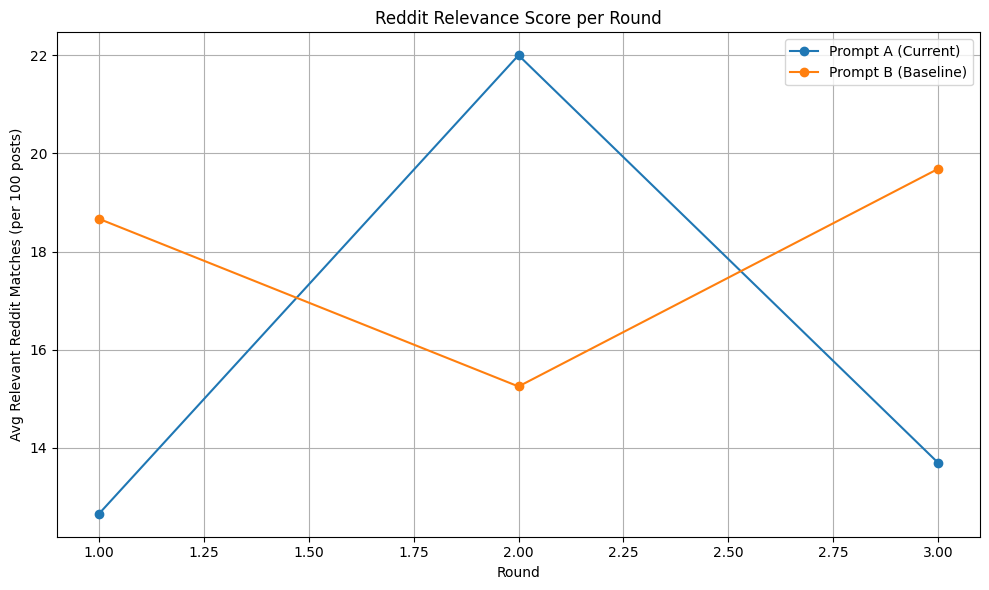

In [18]:
plot_prompt_scores(results)


In [27]:
import praw

# Replace with your actual credentials
reddit = praw.Reddit(
    client_id="L_nmG8JZf59KOgT1tQBGlw",
    client_secret="yCsedpckhc85utc1iTjKj2MBGil0jA",
    user_agent="new_app_erez/0.1 by u/FindingKindly2754"
)

# Example search
def search_reddit_posts(query: str, limit=10):
    print(f"🔍 Searching Reddit for: '{query}'")
    results = reddit.subreddit("all").search(query, limit=limit)
    return [post.title for post in results]

# Try it!
posts = search_reddit_posts("cheap electric car")
for i, title in enumerate(posts, 1):
    print(f"{i}. {title}")


🔍 Searching Reddit for: 'cheap electric car'
1. Brussels launches fightback against cheap Chinese electric cars flooding Europe
2. People don't like electric cars because they look like electric cars.
3. Why EVs are now almost as cheap as gas cars | New electric car prices dropped $2,000 in the U.S. last month, bringing EVs close to price parity with gas-powered cars.
4. Made a custom paint shaker out of a old electric motor I found in a cheap RC car
5. Let the Chinese electric car market obliterate the US auto market until we have super cheap, QUALITY electric cars… then put tariffs back into place.
6. EV Batteries Will Be Half Their 2023 Prices In Three Years: Study -Cheap EV batteries will drive a major rebound in electric car demand in the U.S., Goldman Sachs researchers say
7. Has anybody asked themselves, how much is going to cost to have an all-electric car in the Bay Area when we are dependent on one electric company that can't even handle air-conditioning during the summer and

In [37]:
def count_reddit_results(query: str):
    results = list(reddit.subreddit("all").search(query, limit=None))
    print(f"📊 Found {len(results)} posts for: '{query}'")
    return len(results)


In [38]:
count = count_reddit_results("How do electric SUVs compare to electric sedans for families?")
print(count)

📊 Found 231 posts for: 'How do electric SUVs compare to electric sedans for families?'
231
